In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
#from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
#from sklearn.svm import SVC
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.base import clone
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
#from sklearn import preprocessing
#from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
#from collections import Counter
!pip install imblearn
import sklearn.externals
import joblib
from imblearn.over_sampling import RandomOverSampler, SMOTE
from IPython.display import display

In [ ]:
class Results:
    
    def __init__(self, X, df):
        '''
        Constructor 
        -> Takes Raw X and DataFrame (df)
        '''
        self.X = X.copy()
        self.df = df.copy()
        self.mapping = {1 : "positive", 0 : "negative", 2 : "neutral"}
        self.trainingScore = {}
        self.testingScore = {}
        
    def compareModels(self):
        '''
        Compare Training & Testing Accuracies of All Machine Learning Models
        '''
        df_train = pd.DataFrame(pd.Series(self.trainingScore, name = 'Accuracy'))
        plot = df_train.plot(kind = 'bar', grid = True, title = "Comparison of Training Accuracy")
        plot.set_xlabel("Models")
        plot.set_ylabel("Stance Accuracy")
        fig = plot.get_figure()
        fig.savefig("Untitled Folder 4/Training_Comparison.png", bbox_inches = 'tight')
        df_test = pd.DataFrame(pd.Series(self.testingScore, name = 'Accuracy'))
        plot = df_test.plot(kind = 'bar', grid = True, title = "Comparison of Testing Accuracy")
        plot.set_xlabel("Models")
        plot.set_ylabel("Stance Accuracy")
        fig = plot.get_figure()
        fig.savefig("Untitled Folder 4/Testing_Comparison.png", bbox_inches = 'tight')
        
    def createConfusionMatrix(self, y_true_c, y_pred_c, classifier_name):
        '''
        Function to Generate the Confusion Matrix 
        '''
        y_true = [self.mapping[i] for i in y_true_c]
        y_pred = [self.mapping[i] for i in y_pred_c]
        labels = [self.mapping[key] for key in self.mapping]
        cm = confusion_matrix(y_true, y_pred, labels = labels)
        title = "Confusion Matrix of " + classifier_name
        fig = plt.figure()
        ax = plt.subplot()
        fig.add_subplot(ax)
        sns.heatmap(cm, annot=True, ax = ax);
        ax.set_xlabel('Predicted Labels'); 
        ax.set_ylabel('True Labels');
        ax.set_title(title);
        ax.xaxis.set_ticklabels(labels);
        ax.yaxis.set_ticklabels(labels);
        fig.savefig("Untitled Folder 4/" + title + ".png")
        return
        
    def createGraph(self, randomValues, smoteValues, normalValues, classifierName, typeAccuracy, y_value):
        '''
        Function to Generate Graphs (With K-Cross & Sampling)
        '''
        x_len = max(len(randomValues), len(smoteValues), len(normalValues))
        title = "K-Cross " + typeAccuracy + " Scores of " + classifierName
        x = [i for i in range(1, x_len + 1)]
        plt.title(title)
        plt.plot(x, randomValues, 'o-', label = "Random Sampling")
        plt.plot(x, smoteValues, 'o-', label = "SMOTE Sampling")
        plt.plot(x, normalValues, 'o-', label = "No Sampling")
        plt.xticks([i for i in range(1, x_len + 1)])
        plt.legend()
        plt.grid(True)
        plt.ylabel(y_value + " Accuracy")
        plt.xlabel("Folds")
        plt.legend()
        plt.savefig("Untitled Folder 4/" + title + ".png")
        plt.show()
        
    def getValue(self, y_value):
        '''
            y_value can be 'positive' OR 'negative' OR 'neutral'
            Internal Method, not to be used by user
            returns X,Y
        '''
        X = self.X.copy()
        df = self.df.copy()
        Y = pd.DataFrame()
        Y[y_value] = df[y_value]
        return X,Y
    
    def process(self, X_train, y_train, X_test, y_test):
        '''
            y_value can be 'positive' OR 'negative' OR 'neutral'
            return in the order x_train, y_train, x_test, y_test
            Xs should be dataframes and Ys should be np array
        '''
        tfidf = TfidfVectorizer(use_idf = True, min_df = 0.01, max_df = 0.9)
        x_train = tfidf.fit_transform(list(X_train['Tweet'].values))
        import pickle
        pickle.dump(tfidf,open("tf.pkl","wb"))
        x_test = tfidf.transform(list(X_test['Tweet'].values))
        x_train = x_train.toarray()
        x_test = x_test.toarray()
        x_train = pd.DataFrame(data = x_train, columns = list(tfidf.get_feature_names()))
        x_test = pd.DataFrame(data = x_test, columns = list(tfidf.get_feature_names()))
        del X_train['Tweet']
        del X_test['Tweet']
        x_train = pd.concat([X_train, x_train], axis=1)
        x_test = pd.concat([X_test, x_test], axis=1)
        # print("This is to check all x_train columns are unique")
        assert(len(list(x_train.columns)) == len(set(list(x_train.columns))))
        assert(list(x_train.columns) == list(x_test.columns))
        column = list(x_train.columns)
        x_train = x_train.values
        x_test = x_test.values
        y_train = y_train.reshape(-1)
        y_test = y_test.reshape(-1)
        return x_train,y_train,x_test,y_test

    def evaluate(self, classifier, y_value, classifier_name = None, method = None):
        '''
            y_value can be 'positive' OR 'negative' OR 'neutral'
            Prints Accuracy and Confusion Matrix
            Classifier is sklearn classifier object
            y_value is either 'positive' OR 'negative' OR 'neutral'
            method is the oversampling objects, supports SMOTE etc..
        '''
        X,Y = self.getValue(y_value)
        X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, random_state = 20)
        X_train.reset_index(inplace=True,drop=True)
        X_test.reset_index(inplace=True,drop=True)
        y_train = y_train.values
        y_test = y_test.values
        x_train, y_train, x_test, y_test = self.process(X_train,y_train,X_test,y_test)
        if method is not None:
            x_train, y_train = method().fit_resample(x_train, y_train)
        training_score,testing_score = self.runModel(x_train, x_test, y_train, y_test, classifier)
        print("Training Accuracy : ", round((training_score * 100), 2))
        print("Testing Accuracy  : ", round((testing_score * 100), 2))
        if classifier_name is not None:
            self.createConfusionMatrix(y_test, classifier.predict(x_test), classifier_name)
            self.testingScore[classifier_name] = testing_score
            self.trainingScore[classifier_name] = training_score
        return

    def runModel(self, x_train, x_test, y_train, y_test, classifier):
        '''
            returns training_score,testing_score
            Takes processed x and y 
        '''
        classifier.fit(x_train, y_train)
        #from sklearn.externals import joblib 
        # Save the model as a pickle in a file 
        joblib.dump(classifier, 'mod.pkl') 
        training_score = classifier.score(x_train, y_train)
        testing_score = classifier.score(x_test, y_test)
        return training_score, testing_score
    
    def kcross(self, classifier, y_value, classifierName = None):
        '''
            y_value can be 'positive' OR 'negative' OR 'neutral'
            Prints Complete K-Cross Validation Scores Including Oversampling Techinques
        '''
        training_scores, testing_scores = [], []
        training_scores_random, testing_scores_random = [], []
        training_scores_smote, testing_scores_smote = [], []
        X, Y = self.getValue(y_value)
        skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
        for train_index, test_index in skf.split(X, Y):
            X_train, X_test = X[X.index.isin(train_index)].copy(), X[X.index.isin(test_index)].copy()
            y_train, y_test = Y[Y.index.isin(train_index)].copy(), Y[Y.index.isin(test_index)].copy()
            X_train.reset_index(inplace=True, drop=True)
            X_test.reset_index(inplace=True, drop=True)
            y_train = y_train.values
            y_test = y_test.values
            x_train, y_train, x_test, y_test = self.process(X_train, y_train, X_test, y_test)
            #### SMOTE Over-Sampling #####
            x_train_smote, y_train_smote = SMOTE().fit_resample(x_train, y_train)
            train_smote_score, test_smote_score = self.runModel(x_train_smote, x_test, y_train_smote, y_test, clone(classifier))
            training_scores_smote.append(train_smote_score)
            testing_scores_smote.append(test_smote_score)
            ### Random Over-Sampling #####
            x_train_random, y_train_random = RandomOverSampler().fit_resample(x_train, y_train)
            train_random_score, test_random_score = self.runModel(x_train_random, x_test, y_train_random, y_test, clone(classifier))
            training_scores_random.append(train_random_score)
            testing_scores_random.append(test_random_score)
            ##### No Over-Sampling ###########
            train_score, test_score = self.runModel(x_train, x_test, y_train, y_test, clone(classifier))
            training_scores.append(train_score)
            testing_scores.append(test_score)
        print("Random Sampling Scores : ")
        try:
            print("AVERAGE TRAINING SCORE : ", round(100 * (sum(training_scores_random) / len(training_scores_random)), 2))
        except:
            print("Some Error !")
        try:
            print("AVERAGE TESTING SCORE", round(100 * (sum(testing_scores_random) / len(testing_scores_random)), 2))
        except:
            print("Some Error !")
        print("SMOTE Sampling Scores : ")
        try:
            print("AVERAGE TRAINING SCORE : ", round(100 * (sum(training_scores_smote) / len(training_scores_smote)), 2))
        except:
            print("Some Error !")
        try:
            print("AVERAGE TESTING SCORE : ", round(100 * (sum(testing_scores_smote) / len(testing_scores_smote)), 2))
        except:
            print("Some Error !")
        
        print("Normal Scores (No Sampling) : ")
        try:
            print("AVERAGE TRAINING SCORE : ", round(100 * (sum(training_scores) / len(training_scores)), 2))
        except:
            print("Some Error !")
        try:
            print("AVERAGE TESTING SCORE : ", round(100 * (sum(testing_scores)/len(testing_scores)), 2))
        except:
            print("Some Error !")
        if classifierName is not None:
            self.createGraph(training_scores_random, training_scores_smote, training_scores, classifierName, "Training ", y_value.lower().capitalize())
            self.createGraph(testing_scores_random, testing_scores_smote, testing_scores, classifierName,"Validation ", y_value.lower().capitalize())


In [ ]:
df = pd.read_csv("Preprocessed_Dataset.csv")

In [ ]:
df.head()

,Unnamed: 0,Tweet,Pos/Neg/Neu
0,0,"coronavirus masks: types, protection, use",negative
1,1,"coronavirus may give us justice, failed get go...",negative
2,2,imagine grand opening construction big mosque ...,negative
3,3,depend coronavirus _in. extend justice us.,negative
4,4,empowerful life lessons strong healthy safe ha...,positive


In [ ]:
df = df.drop(columns=["Unnamed: 0"])
df.head()

,Tweet,Pos/Neg/Neu
0,"coronavirus masks: types, protection, use",negative
1,"coronavirus may give us justice, failed get go...",negative
2,imagine grand opening construction big mosque ...,negative
3,depend coronavirus _in. extend justice us.,negative
4,empowerful life lessons strong healthy safe ha...,positive


In [ ]:
cols = list(df.columns)
index = cols.index("Tweet")

In [ ]:
print(cols)
print(index)

['Tweet', 'Pos/Neg/Neu']
0


In [ ]:
nanIndex = []
nanIndex.extend(list(df[df["Pos/Neg/Neu"].isna()].index))
for i in range(index,len(cols)):
    print("Checking : ", cols[i])
    nanIndex.extend(list(df[df[cols[i]].isna()].index))
nanIndex = set(nanIndex)
print("Total NaN Value Found : ",len(nanIndex))

Checking :  Tweet
Checking :  Pos/Neg/Neu
Total NaN Value Found :  0


In [ ]:
df.drop(index = nanIndex, inplace = True)
df.reset_index(inplace = True, drop = True)

In [ ]:
rep = {"Pos/Neg/Neu" : {"negative" : 0, "positive" : 1, "neutral" : 2}}
df.replace(rep, inplace = True)

In [ ]:
df.head()

,Tweet,Pos/Neg/Neu
0,"coronavirus masks: types, protection, use",0
1,"coronavirus may give us justice, failed get go...",0
2,imagine grand opening construction big mosque ...,0
3,depend coronavirus _in. extend justice us.,0
4,empowerful life lessons strong healthy safe ha...,1


In [ ]:
X  = pd.DataFrame(df.iloc[:,index].copy())
print(type(X))
X.head()

<class 'pandas.core.frame.DataFrame'>


,Tweet
0,"coronavirus masks: types, protection, use"
1,"coronavirus may give us justice, failed get go..."
2,imagine grand opening construction big mosque ...
3,depend coronavirus _in. extend justice us.
4,empowerful life lessons strong healthy safe ha...


In [ ]:
result = Results(X, df)

Random Sampling Scores : 
AVERAGE TRAINING SCORE :  82.02
AVERAGE TESTING SCORE 72.67
SMOTE Sampling Scores : 
AVERAGE TRAINING SCORE :  83.36
AVERAGE TESTING SCORE :  74.4
Normal Scores (No Sampling) : 
AVERAGE TRAINING SCORE :  84.71
AVERAGE TESTING SCORE :  82.72


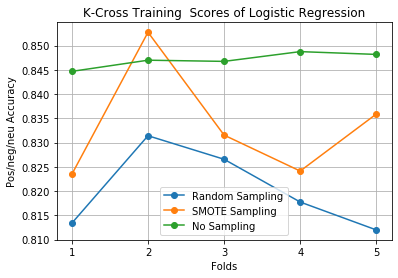

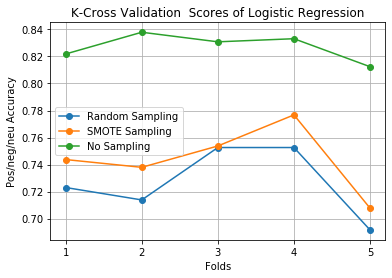

In [ ]:
result.kcross(LogisticRegression(C=1, penalty='l2', multi_class='ovr'), 'Pos/Neg/Neu', "Logistic Regression")

Random Sampling Scores : 
AVERAGE TRAINING SCORE :  82.56
AVERAGE TESTING SCORE 73.5
SMOTE Sampling Scores : 
AVERAGE TRAINING SCORE :  84.11
AVERAGE TESTING SCORE :  73.41
Normal Scores (No Sampling) : 
AVERAGE TRAINING SCORE :  85.37
AVERAGE TESTING SCORE :  82.84


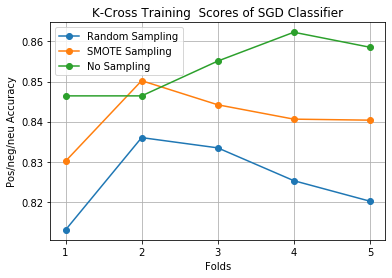

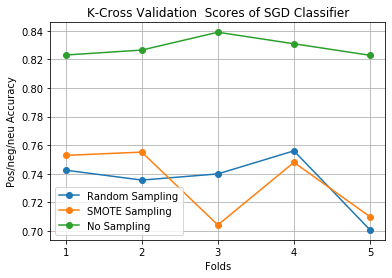

In [ ]:
result.kcross(SGDClassifier(alpha=.0001, max_iter=50, loss='log', penalty="elasticnet"), 'Pos/Neg/Neu', "SGD Classifier")

Random Sampling Scores : 
AVERAGE TRAINING SCORE :  90.86
AVERAGE TESTING SCORE 81.04
SMOTE Sampling Scores : 
AVERAGE TRAINING SCORE :  90.91
AVERAGE TESTING SCORE :  80.7
Normal Scores (No Sampling) : 
AVERAGE TRAINING SCORE :  90.65
AVERAGE TESTING SCORE :  84.91


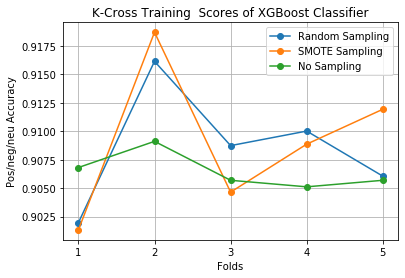

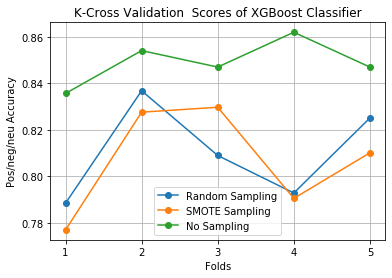

In [ ]:
result.kcross(XGBClassifier(max_depth=3,n_estimators=300,learning_rate=0.1), 'Pos/Neg/Neu', "XGBoost Classifier")

Random Sampling Scores : 
AVERAGE TRAINING SCORE :  75.37
AVERAGE TESTING SCORE 69.77
SMOTE Sampling Scores : 
AVERAGE TRAINING SCORE :  76.39
AVERAGE TESTING SCORE :  71.24
Normal Scores (No Sampling) : 
AVERAGE TRAINING SCORE :  81.55
AVERAGE TESTING SCORE :  80.47


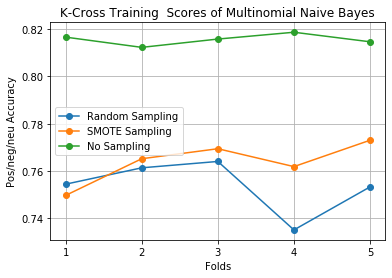

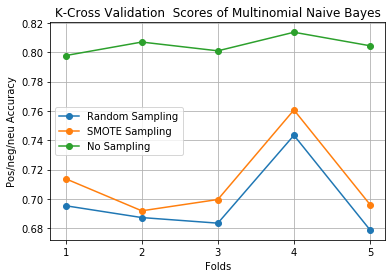

In [ ]:
result.kcross(MultinomialNB(), 'Pos/Neg/Neu', "Multinomial Naive Bayes")

Random Sampling Scores : 
AVERAGE TRAINING SCORE :  95.91
AVERAGE TESTING SCORE 85.48
SMOTE Sampling Scores : 
AVERAGE TRAINING SCORE :  96.89
AVERAGE TESTING SCORE :  86.5
Normal Scores (No Sampling) : 
AVERAGE TRAINING SCORE :  97.83
AVERAGE TESTING SCORE :  88.98


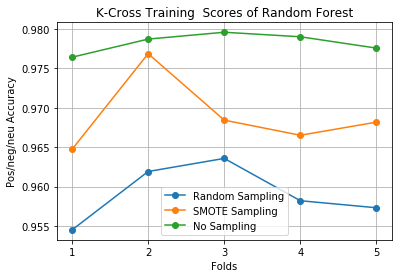

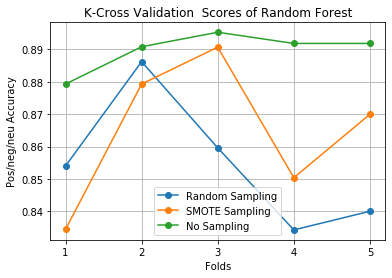

In [ ]:
result.kcross(RandomForestClassifier(n_estimators=90,random_state=30,oob_score=True,max_features='auto'),'Pos/Neg/Neu',"Random Forest")

Training Accuracy :  84.79
Testing Accuracy  :  83.99


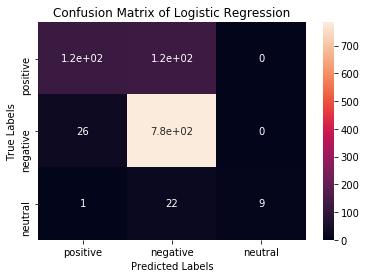

In [ ]:
result.evaluate(LogisticRegression(C=1, penalty='l2', multi_class='ovr'), 'Pos/Neg/Neu', "Logistic Regression")

Training Accuracy :  85.8
Testing Accuracy  :  85.1


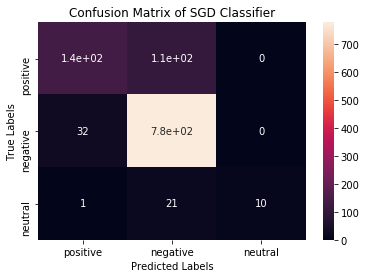

In [ ]:
result.evaluate(SGDClassifier(alpha=.0001, max_iter=50, loss='log', penalty="elasticnet"), 'Pos/Neg/Neu', "SGD Classifier")

Training Accuracy :  90.55
Testing Accuracy  :  85.19


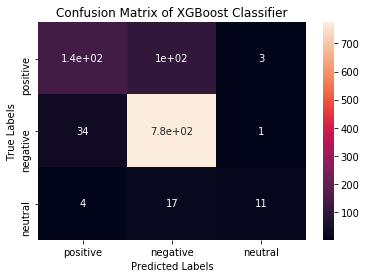

In [ ]:
result.evaluate(XGBClassifier(max_depth=3,n_estimators=300,learning_rate=0.1), 'Pos/Neg/Neu', "XGBoost Classifier")

Training Accuracy :  81.96
Testing Accuracy  :  81.42


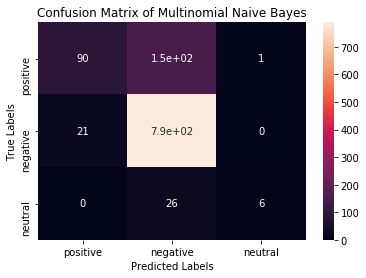

In [ ]:
result.evaluate(MultinomialNB(),'Pos/Neg/Neu',"Multinomial Naive Bayes")

Training Accuracy :  97.82
Testing Accuracy  :  90.25


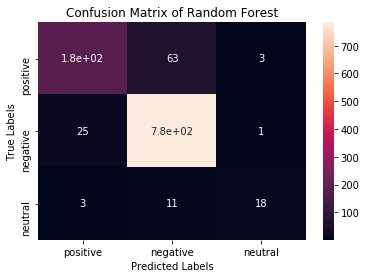

In [ ]:
result.evaluate(RandomForestClassifier(n_estimators=90,random_state=30,oob_score=True,max_features='auto'),'Pos/Neg/Neu',"Random Forest")

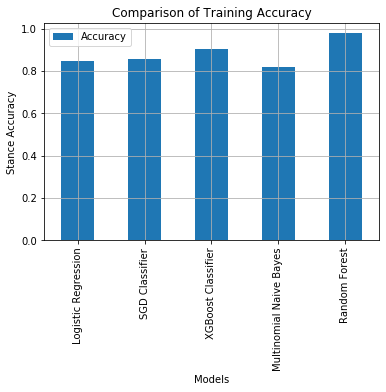

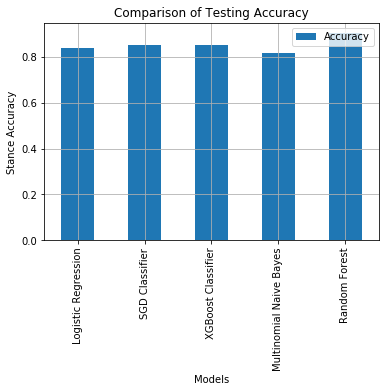

In [ ]:
result.compareModels()